## Comparison to BLAST

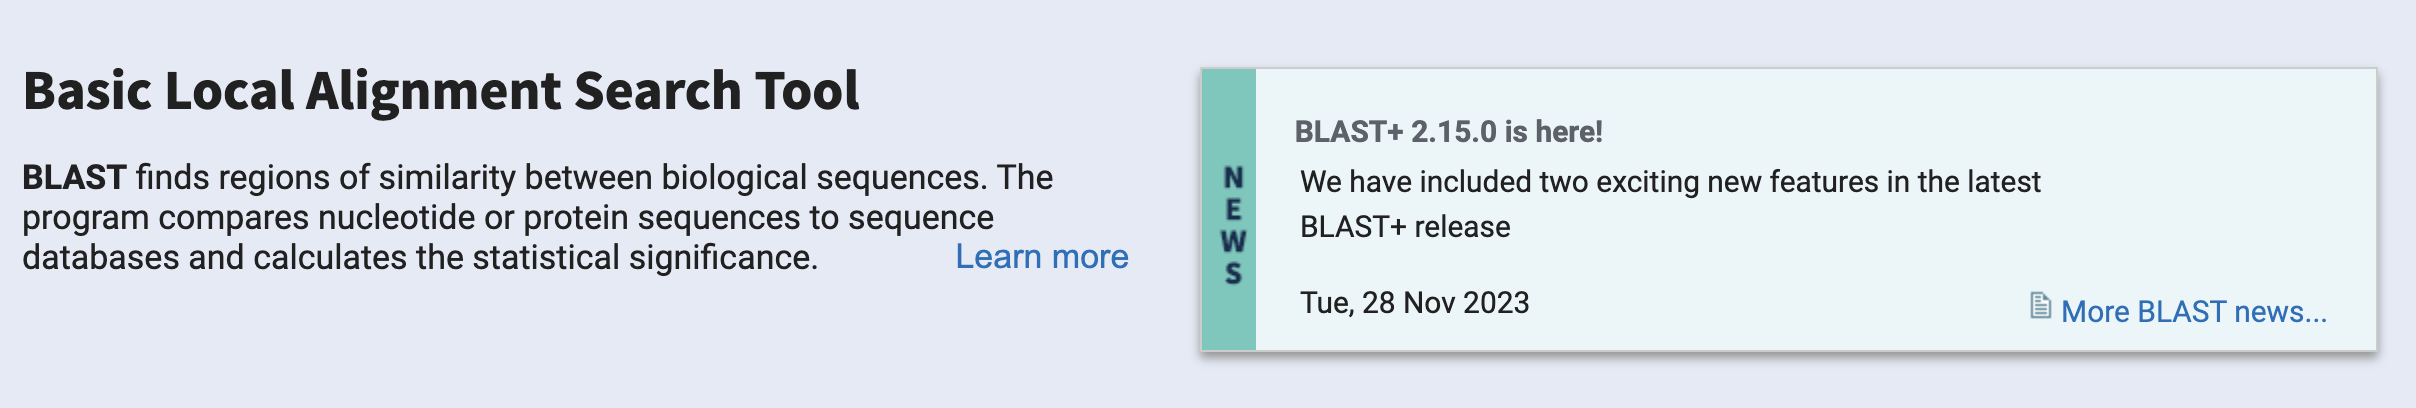

#### Install Blast tools

* https://blast.ncbi.nlm.nih.gov/doc/blast-help/downloadblastdata.html
* https://www.ncbi.nlm.nih.gov/books/NBK279690/

#### Compare our prediction with BLAST Tools

In [1]:
import pandas as pd
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import json
from tqdm import tqdm
import sklearn.metrics as metrics
from BLAST.utils import metric

In [2]:
df = pd.read_csv('./BLAST/src/testset.csv')

In [3]:
df.head()

,id,sequence,length,class
0,Thhalv10001938m -- EIL,MMMFNEMGMYGKMDFFSSTSLGEIDVCPLPQAEQDHPVVEEDYTDD...,582,EIL
1,Tp1g37880 -- EIL,MGVFFSDPDSIAEDDGYTDNELDVDELEKRIWKQEMRLRRLKEHRK...,211,EIL
2,Pbr004574.1 -- EIL,MGDVGEIGPDISSDIEEDLRCDNIAEKDVSDEEIEAEDLERRMWKD...,608,EIL
3,Sme2.5_02278.1_g00005.1 -- EIL,MNNEVVEENQEFDDEEINYDDLKRRMWKDRMRMQILKGKKRDMMIE...,494,EIL
4,ONIVA11G15950.1 -- EIL,MDASKKSVMTKEEQQLSPAASPAAAVMTAEADAINEEQDKAAAATT...,466,EIL


In [4]:
records = []
for i, row in df.iterrows():
    record = SeqRecord(Seq(row['sequence']), id=str(i+1), description=" | " + row['class'])
    records.append(record)

# Save to a FASTA file
output_file = "./BLAST/testset.fasta"
SeqIO.write(records, output_file, "fasta")

print(f"FASTA file saved as {output_file}")

FASTA file saved as ./BLAST/testset.fasta


#### Build reference(train) database for blast

In [5]:
ref_pah = "../data/mix_data/trainset"

In [6]:
gene_info_path = "../data/gene_info.json"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [7]:
records = []
for gene, info in tqdm(gene_info.items()):
    path = f"{ref_pah}/{info['file_code']}.csv"
    df_gene = pd.read_csv(path)
    df_gene = df_gene[df_gene['class'] == 1]
    
    # write
    for _, row in df_gene.iterrows():
        record = SeqRecord(Seq(row['sequence']), id=row['id'] + "--" + gene, description="")
        records.append(record)

# Save to a FASTA file
output_file = "./BLAST/trainset.fasta"
SeqIO.write(records, output_file, "fasta")
print(f"FASTA file saved as {output_file}")

100%|███████████████████████████████████████████| 58/58 [00:09<00:00,  6.35it/s]


FASTA file saved as ./BLAST/trainset.fasta


#### BUILD DATABASE FOR BLAST

In [8]:
!makeblastdb -in ./BLAST/trainset.fasta -dbtype prot -out ./BLAST/database/pygenomics_ref_db



Building a new DB, current time: 07/07/2024 09:42:23
New DB name:   /Users/genereux/Documents/UM6P/COURS-S2/S2-PROJECT/pygenomics/test/BLAST/database/pygenomics_ref_db
New DB title:  ./BLAST/trainset.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/genereux/Documents/UM6P/COURS-S2/S2-PROJECT/pygenomics/test/BLAST/database/pygenomics_ref_db
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 256279 sequences in 4.78068 seconds.




#### RUN BLAST SEARCH TOOL

In [16]:
#!blastp -query ./BLAST/testset.fasta -db ./BLAST/database/pygenomics_ref_db -out ./BLAST/blast_result.txt -outfmt 6 -evalue 1e-5 -num_threads 112

#### View Blast Analysis results

In [18]:
columns = [
    "query_id", "subject_id", "perc_identity", "alignment_length",
    "mismatches", "gap_opens", "q_start", "q_end", "s_start", "s_end",
    "evalue", "bit_score"
]
blast_results = pd.read_csv("./BLAST/blast_result.txt", sep="\t", names=columns)
#blast_results.to_csv("./BLAST/blast_results.csv", index=False)

# Display the first few rows of the DataFrame
blast_results.head()

,query_id,subject_id,perc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,1,676714038--EIL,89.696,592,49,6,1,581,1,591,0.0,1063.0
1,1,XP_013629559.1--EIL,84.628,592,59,10,1,581,1,571,0.0,1001.0
2,1,GSBRNA2T00066199001--EIL,83.277,592,59,10,1,581,1,563,0.0,980.0
3,1,XP_009133914.1--EIL,85.135,592,56,10,1,581,1,571,0.0,977.0
4,1,XP_009133916.1--EIL,85.135,592,56,10,1,581,1,571,0.0,977.0


#### Proccessing to make final inference base on threshold

In [19]:
voting_threshold = 50
unique_query_ids = sorted(blast_results['query_id'].unique())

predictions = ["Unknown"  for _ in range(len(df))]
for query_id in tqdm(unique_query_ids, desc="Max Voting : "):
    filtered_df = blast_results[blast_results['query_id'] == query_id]
    
    # Find the row with the highest perc_identity greater than voting_threshold
    best_match = filtered_df[filtered_df['perc_identity'] > voting_threshold].sort_values(by='perc_identity', ascending=False).head(1)
    if not best_match.empty:
        subject_id = best_match.iloc[0]['subject_id']
        subject_id_part = subject_id.split('--')[-1]
        predictions[query_id-1] = (subject_id_part)

blast_prediction = pd.DataFrame({'prediction': predictions})

Max Voting : 100%|████████████████████████| 64037/64037 [15:59<00:00, 66.74it/s]


In [20]:
with open("./BLAST/src/class_mapping.json", 'r') as json_file:
    class_mapping = json.load(json_file)
true_label = pd.read_csv("./BLAST/src/true_labels.csv")

In [21]:
blast_prediction["predicted_label"] = blast_prediction.prediction.map(class_mapping)
blast_prediction.head()

,prediction,predicted_label
0,EIL,1
1,EIL,1
2,EIL,1
3,EIL,1
4,EIL,1


#### Display performance

In [22]:
metric.show_metrics(true_label, blast_prediction.predicted_label)

In [26]:
import importlib
importlib.reload(metric)

<module 'BLAST.utils.metric' from '/Users/genereux/Documents/UM6P/COURS-S2/S2-PROJECT/pygenomics/test/BLAST/utils/metric.py'>


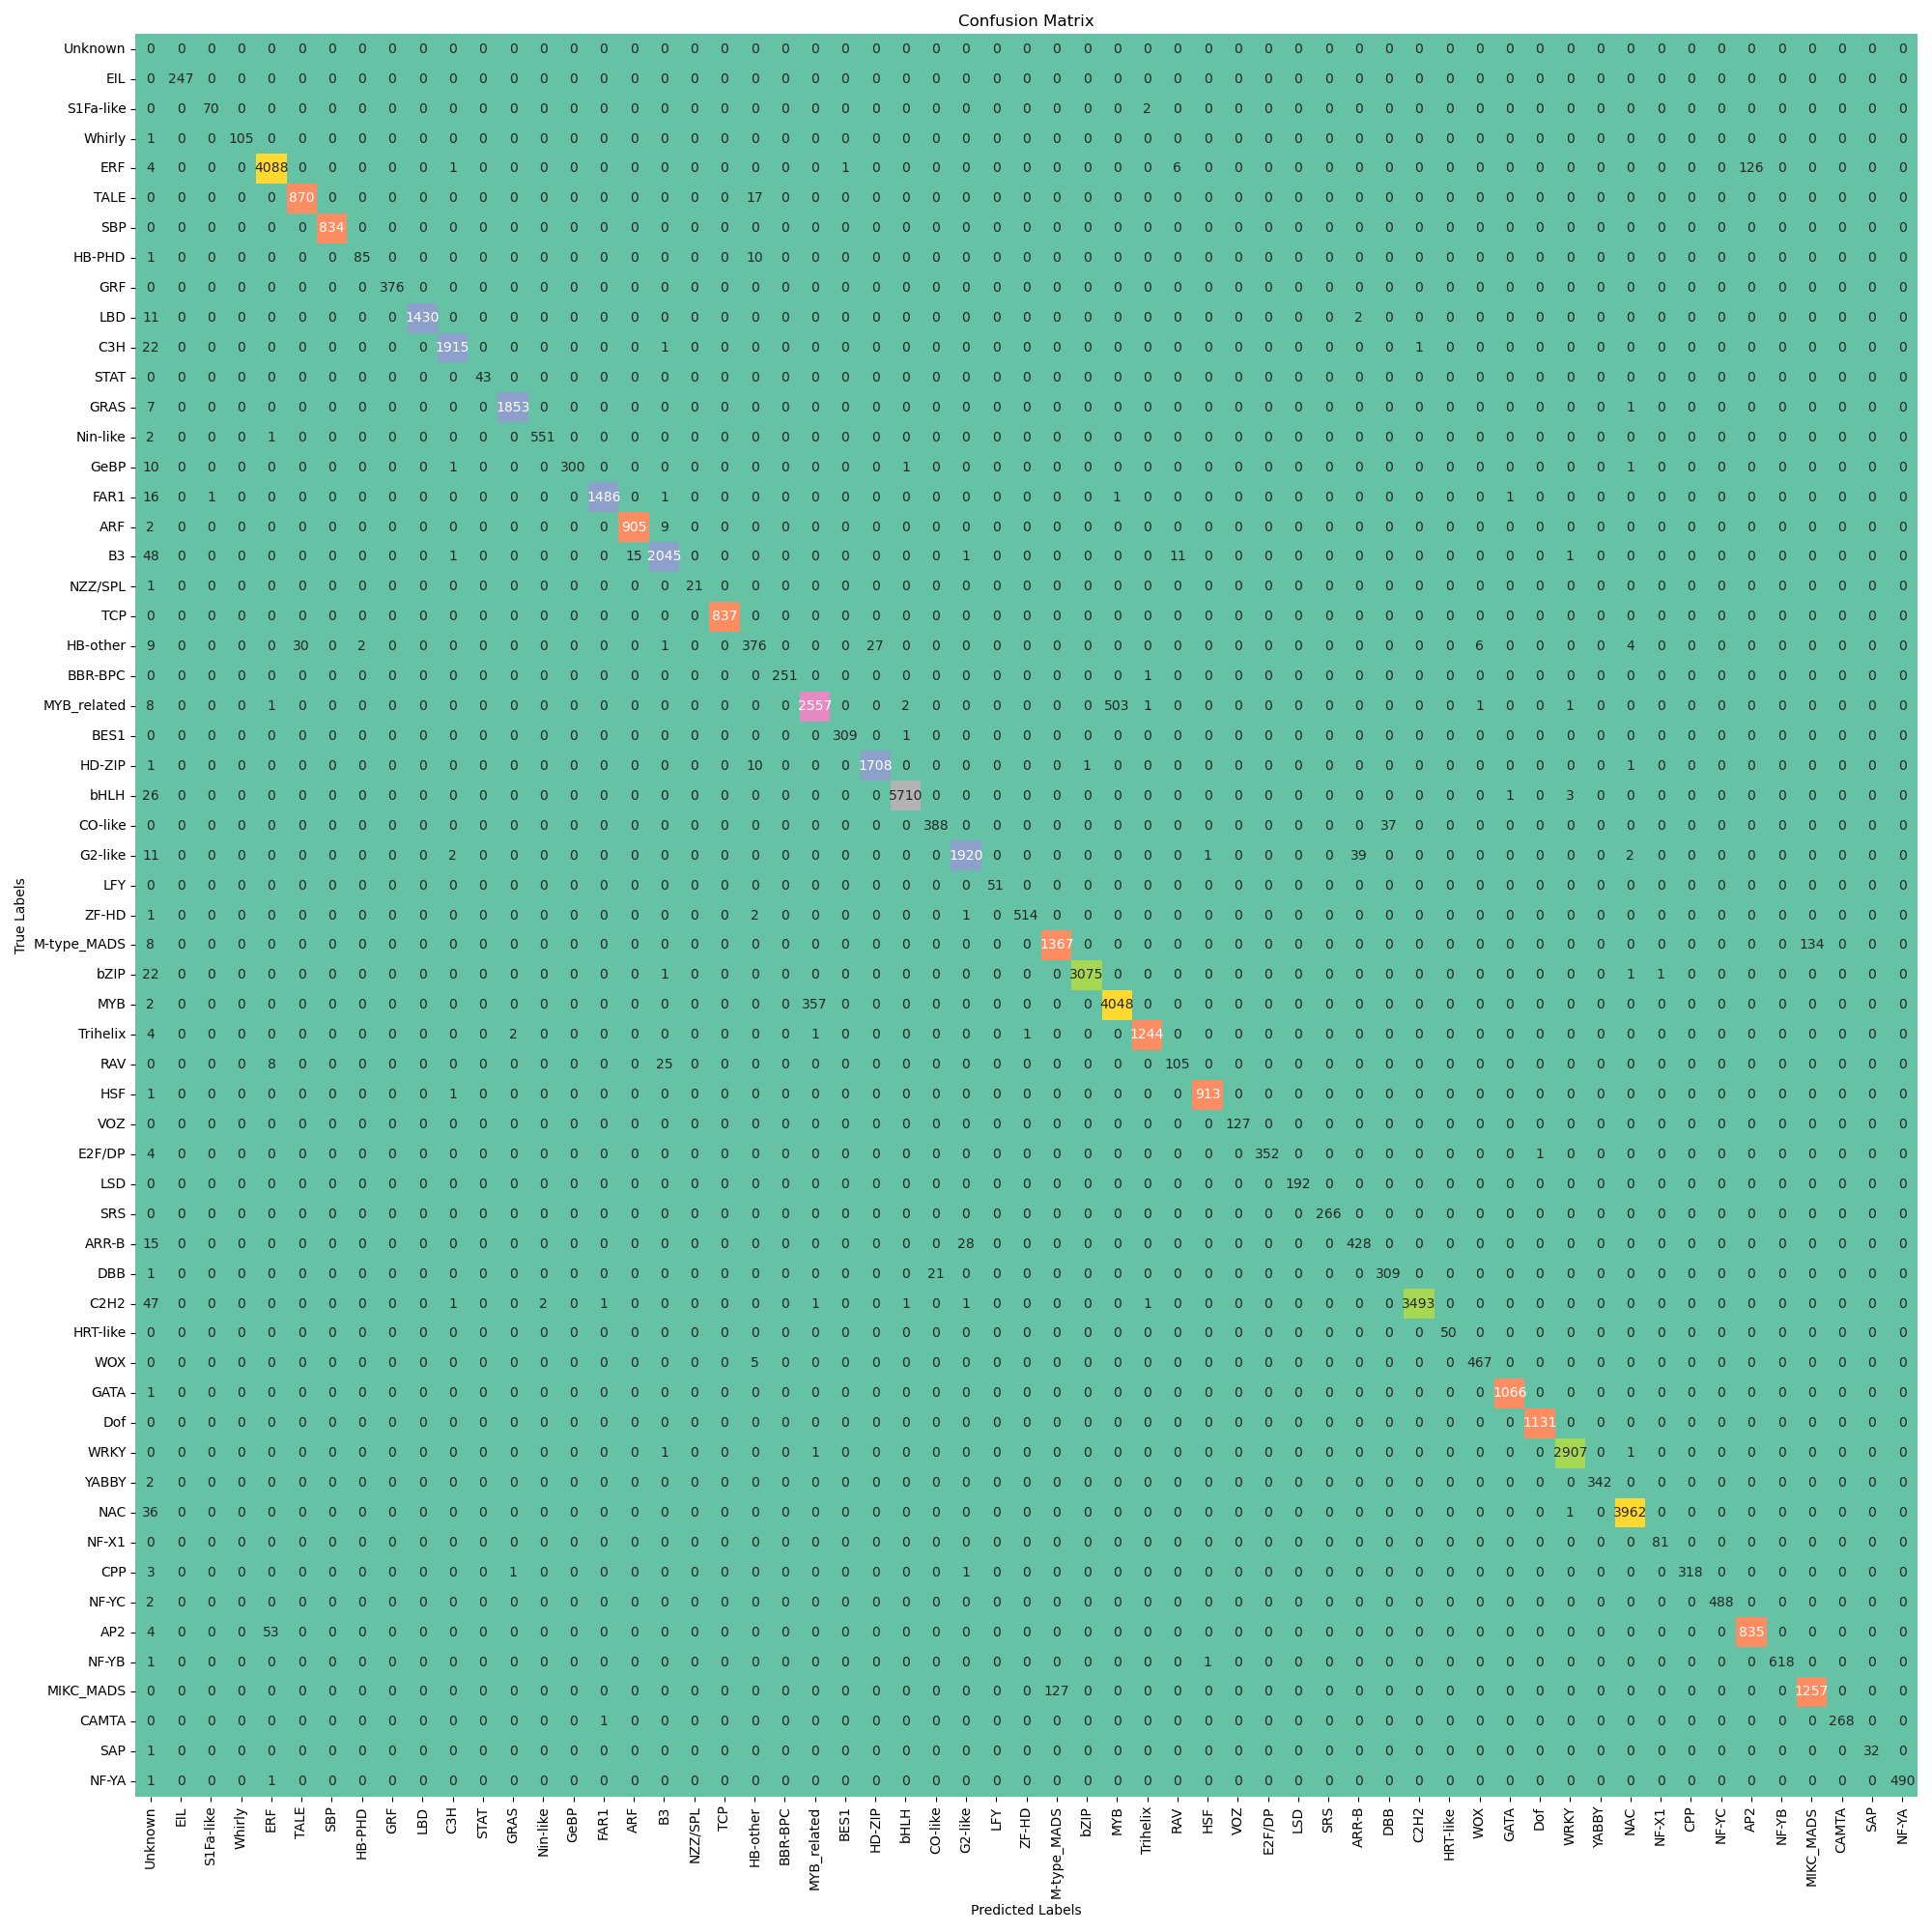

In [27]:
metric.show_confusion(true_label, blast_prediction.predicted_label, class_mapping)